# Lagrangian tools using Parcels and xarray

In [1]:
from parcels import FieldSet, Field
from glob import glob
import os
from os.path import join
import numpy as np
import xarray as xr
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import cmocean
import gsw
from xgcm.grid import Grid

seconds_per_day = 24 * 60 * 60
deg_to_m = 1852 * 60  # m per degree

In [2]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append("../xlcs/")

import lagrangian_tools as lt
import grid_calc
from custommap import *
from contours import extract_contours

# Load 15 day-long velocity fields over the Gulf of Mexico

The velocity field, from sea surface height measured by altimetry, was obtained from http://marine.copernicus.eu.

In [3]:
ds0 = xr.open_dataset("1995-01.nc")
ds0

<xarray.Dataset> Size: 7MB
Dimensions:    (time: 15, latitude: 171, longitude: 173)
Coordinates:
  * latitude   (latitude) float32 684B 7.375 7.625 7.875 ... 49.38 49.62 49.88
  * time       (time) datetime64[ns] 120B 1995-01-01 1995-01-02 ... 1995-01-15
  * longitude  (longitude) float32 692B -98.12 -97.88 -97.62 ... -55.38 -55.12
Data variables:
    ugos       (time, latitude, longitude) float64 4MB ...
    vgos       (time, latitude, longitude) float64 4MB ...
Attributes: (12/45)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Sea Surface Height measur...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1D
    time_coverage_end:                              2021-08-02T12:00:00Z
    time_coverage_resolution:                       P1D
    time_coverage_start:                            2021-08-01T12:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

## Create grid to easily perform derivative with XGCM
- create grid spacing variable (`dx`, `dy`) with values in meters
- because new values are not stored at the same location as the velocity we create two new dimensions
    - `longitude`, `latitude`: The variable values are located at the cell center.
    - `longitude_g`, `latitude_g`: The variable values are located on the cell faces, excluding both outer boundaries.
    - See [Simple Grids](https://xgcm.readthedocs.io/en/latest/grids.html) for more details.
- create the Grid object

In [4]:
ds = ds0.copy(deep=True)


lon, lat = np.meshgrid(ds.longitude, ds.latitude)
ds = ds.assign_coords(
    {
        "dx": xr.DataArray(
            gsw.distance(lon, lat, axis=1),
            dims=["latitude", "longitude_g"],
            coords={
                "latitude": ds.latitude.data,
                "longitude_g": 0.5 * (ds.longitude.data[1:] + ds.longitude.data[:-1]),
            },
        ),
        "dy": xr.DataArray(
            gsw.distance(lon, lat, axis=0),
            dims=["latitude_g", "longitude"],
            coords={
                "latitude_g": 0.5 * (ds.latitude.data[1:] + ds.latitude.data[:-1]),
                "longitude": ds.longitude.data,
            },
        ),
    }
)

In [5]:
ds

<xarray.Dataset> Size: 8MB
Dimensions:      (time: 15, latitude: 171, longitude: 173, longitude_g: 172,
                  latitude_g: 170)
Coordinates:
  * latitude     (latitude) float32 684B 7.375 7.625 7.875 ... 49.38 49.62 49.88
  * time         (time) datetime64[ns] 120B 1995-01-01 1995-01-02 ... 1995-01-15
  * longitude    (longitude) float32 692B -98.12 -97.88 -97.62 ... -55.38 -55.12
  * longitude_g  (longitude_g) float32 688B -98.0 -97.75 -97.5 ... -55.5 -55.25
  * latitude_g   (latitude_g) float32 680B 7.5 7.75 8.0 ... 49.25 49.5 49.75
    dx           (latitude, longitude_g) float64 235kB 2.757e+04 ... 1.792e+04
    dy           (latitude_g, longitude) float64 235kB 2.78e+04 ... 2.78e+04
Data variables:
    ugos         (time, latitude, longitude) float64 4MB ...
    vgos         (time, latitude, longitude) float64 4MB ...
Attributes: (12/45)
    Conventions:                                    CF-1.6
    FROM_ORIGINAL_FILE__Metadata_Conventions:       Unidata Dataset Discovery...
    cdm_data_type:                                  Grid
    comment:                                        Sea Surface Height measur...
    contact:                                        servicedesk.cmems@mercato...
    creator_email:                                  servicedesk.cmems@mercato...
    ...                                             ...
    time_coverage_duration:                         P1D
    time_coverage_end:                              2021-08-02T12:00:00Z
    time_coverage_resolution:                       P1D
    time_coverage_start:                            2021-08-01T12:00:00Z
    title:                                          DT merged all satellites ...
    _CoordSysBuilder:                               ucar.nc2.dataset.conv.CF1...

## XGCM velocity grid object

In [6]:
coords = {
    "X": {"center": "longitude", "inner": "longitude_g"},
    "Y": {"center": "latitude", "inner": "latitude_g"},
}
grid = Grid(ds, periodic=[], coords=coords)
grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   longitude --> inner
  * inner    longitude_g --> center
Y Axis (not periodic, boundary=None):
  * center   latitude --> inner
  * inner    latitude_g --> center

# Trajectories (using OceanParcels)

## Velocity fields
- create the FieldSet for Parcels integration

In [7]:
variables = {"U": "ugos", "V": "vgos"}

dimensions = {
    "time": "time",
    "lon": "longitude",
    "lat": "latitude",
}

fs = FieldSet.from_xarray_dataset(ds, variables, dimensions, mesh="spherical")

In [8]:
fs.time_origin  # validate

1995-01-01T00:00:00.000000000

## Trajectories
- we create a second grid where trajectories will be launched since it does not have to be equal to the velocity grid.

In [9]:
# parameters
t0 = datetime(1995, 1, 15)
adv_time = timedelta(days=10)
adv_dt = -timedelta(hours=6)
pdist = 0.025  # distance in degrees between particles
lon = [-98, -75]
lat = [17, 31]
output_folder = "./"

In [10]:
px = np.arange(lon[0], lon[1] - pdist, pdist)
py = np.arange(lat[0], lat[1] + pdist, pdist)
px_grid, py_grid = np.meshgrid(px, py)

ds_traj = xr.Dataset().assign_coords(
    {
        "dx": xr.DataArray(
            gsw.distance(px_grid, py_grid, axis=1),
            dims=["yc", "xg"],
            coords={"yc": py, "xg": 0.5 * (px[1:] + px[:-1])},
        ),
        "dy": xr.DataArray(
            gsw.distance(px_grid, py_grid, axis=0),
            dims=["yg", "xc"],
            coords={"yg": 0.5 * (py[1:] + py[:-1]), "xc": px},
        ),
    }
)


coords = {
    "X": {"center": "xc", "inner": "xg"},
    "Y": {"center": "yc", "inner": "yg"},
}
grid_traj = Grid(ds_traj, periodic=[], coords=coords)
grid_traj

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   xc --> inner
  * inner    xg --> center
Y Axis (not periodic, boundary=None):
  * center   yc --> inner
  * inner    yg --> center

In [11]:
pset, id0 = lt.flowmap(
    ds_traj,
    join(output_folder, f"ftle_{t0.strftime('%Y%m%d')}.zarr"),
    fs,
    t0,
    adv_time,
    adv_dt,
)

INFO: Output files are stored in ./ftle_19950115.zarr.
100%|███████████████████████████████████████████████████████████████████████████████| 864000.0/864000.0 [00:18<00:00, 47386.30it/s]


# Cauchy Green (CG) tensor

The tensor is obtained from derivatives, ${C_{t_{0}}^{t_{1}}=\left[\nabla F_{t_{0}}^{t_{1}}\right]^{T}\nabla F_{t_{0}}^{t_{1}}} $, of the flowmap (`phi_x`, `phi_y`, stored in `ds_traj`). It represents the deformation or stretching in the fluids. The eigenvalue of the CG are proportional to the maximum relative streching of particles initially at a distance $\delta_x$ after the $T$-long intergration/


We can take a first look at the flowmap, which is a vector quantity defined at the initial location of a trajectory that represents it's final position. For example, if we have a trajectory at $t=0$ defined at (-80˚W, 25˚N) that end up at (-75˚W, 21˚N) after $T$ unit of integration: `phi_x(-80˚W, 25˚N) = -75˚W` and `phi_y(-80˚W, 25˚N) = 21˚N`.

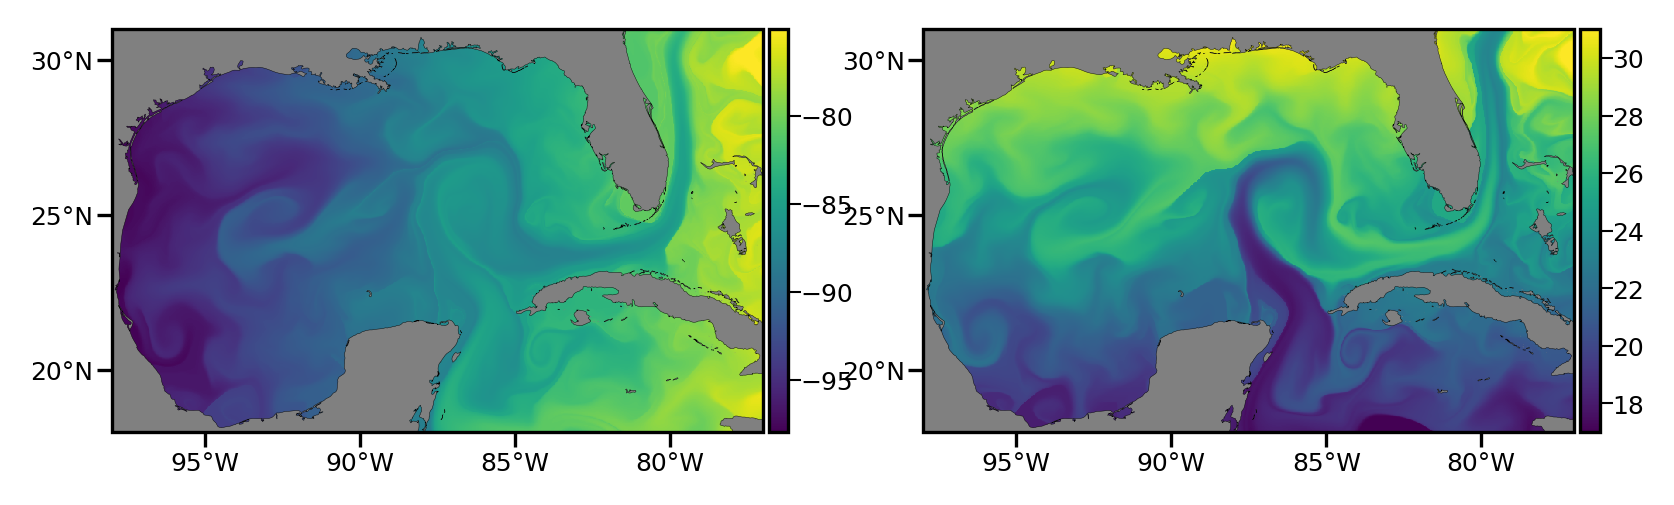

In [12]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1, 2, 1, aspect="equal", projection=ccrs.PlateCarree())
ax2 = fig.add_subplot(1, 2, 2, aspect="equal", projection=ccrs.PlateCarree())

pcm = ax1.pcolormesh(
    ds_traj.xc, ds_traj.yc, ds_traj.phi_x, transform=ccrs.PlateCarree()
)
gom_map(ax1)
add_colorbar(fig, ax1, pcm, range_limit=[min(ds_traj.xc), max(ds_traj.xc)])
pcm = ax2.pcolormesh(ds_traj.xc, ds_traj.yc, ds_traj.phi_y)
gom_map(ax2)
add_colorbar(fig, ax2, pcm, range_limit=[min(ds_traj.yc), max(ds_traj.yc)])

## Evaluate the Flowmap derivatives to construct the Cauchy-Green tensor

In [13]:
lt.cauchygreen(ds_traj, grid_traj)
lmin, lmax, vmin, vmax, ftle = lt.eigenspectrum(
    np.nan_to_num(ds_traj.cg.values), adv_time.days * seconds_per_day
)
ds_traj["ftle"] = (("yc", "xc"), ftle)

/Users/pmiron/micromamba/envs/xlcs/lib/python3.12/site-packages/xgcm/grid_ufunc.py:832: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  out_dim: grid._ds.dims[out_dim] for arg in out_core_dims for out_dim in arg
/Users/pmiron/micromamba/envs/xlcs/lib/python3.12/site-packages/xarray/namedarray/core.py:514: UserWarning: Duplicate dimension names present: dimensions {'dim'} appear more than once in dims=('yc', 'xc', 'dim', 'dim'). We do not yet support duplicate dimension names, but we do allow initial construction of the object. We recommend you rename the dims immediately to become distinct, as most xarray functionality is likely to fail silently if you do not. To rename the dimensions you will need to set the ``.dims`` attribute of each variable, ``e.g. var.dims=('x0', 'x1')``.
  warnings.

## Plot results

### Finite Time Lyapunov Exponent (FTLE) and Lagrangian Averaged Vorticity Deviation (LAVD)

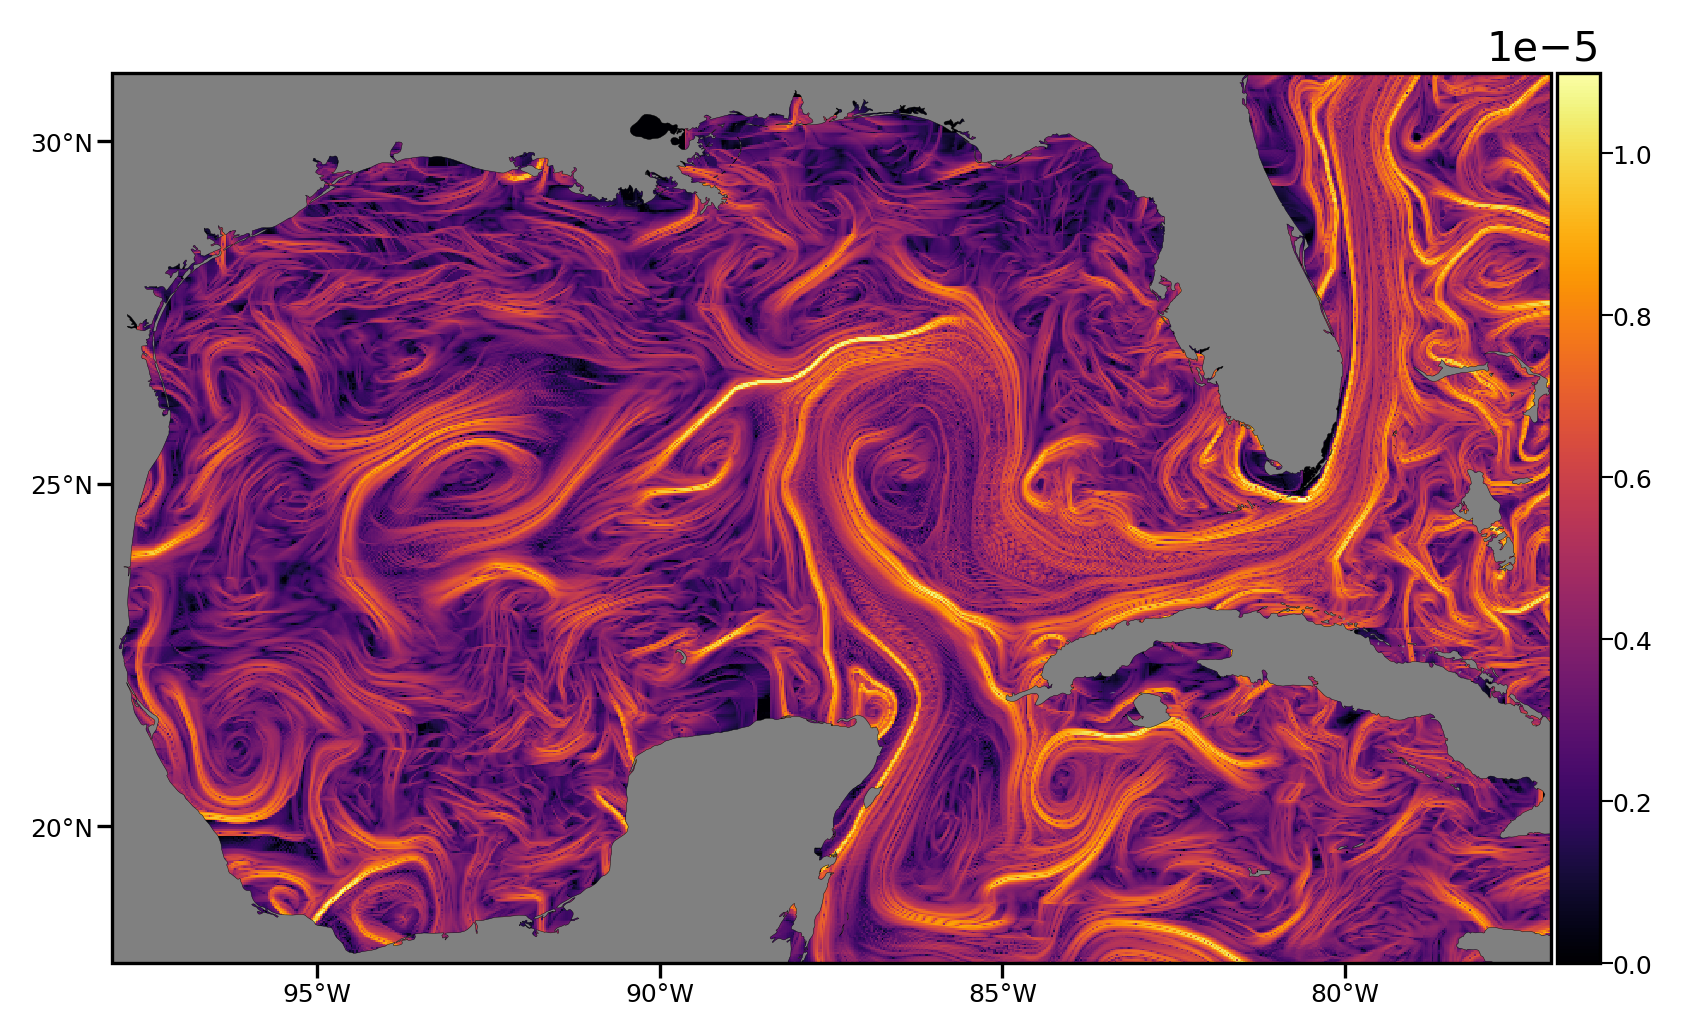

In [14]:
fig = plt.figure(dpi=300)
ax1 = fig.add_subplot(1, 1, 1, aspect="equal", projection=ccrs.PlateCarree())

ftle[ftle < 0] = 0  # only positive values are meaningful
pcm = ax1.pcolormesh(ds_traj.xc, ds_traj.yc, ds_traj.ftle, cmap="inferno")
gom_map(ax1)
add_colorbar(fig, ax1, pcm)